In [27]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

# import tensorflow
import tensorflow as tf
from tensorflow import keras

# import keras
from keras.callbacks import EarlyStopping
from tensorflow.python.keras.models import load_model
from keras.api._v2.keras import activations
from keras.engine.sequential import Sequential
from tensorflow.keras.layers import LSTM, Dense

# import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# 1. Create Data Set

## 1-1. Google Drive connect and files load

In [2]:
drive.mount('/content/drive') # 코랩에서 구글 드라이브에 마운트

Mounted at /content/drive


In [35]:
drive_path = '/content/drive/MyDrive/PNUProject/AIProject/data'
file_list = os.listdir(drive_path)
file_list

['ma.csv', 'macd.csv', 'rsi.csv', 'bb.csv', 'historydata_v1.csv']

In [36]:
df_list = []
for i in range(0,len(file_list),1):
  path = drive_path + '/' + file_list[i]
  data = pd.read_csv(path, encoding='cp949')
  path = ''
  df_list.append(data)

In [37]:
df_list[4].tail()

,open,high,low,close,volume,candel_date_time
19995,31436000.0,31497000.0,31312000.0,31469000.0,440.991947,2023-02-20 11:00:00
19996,31469000.0,31595000.0,31425000.0,31570000.0,327.507823,2023-02-20 12:00:00
19997,31570000.0,31680000.0,31554000.0,31619000.0,280.676325,2023-02-20 13:00:00
19998,31603000.0,31640000.0,31520000.0,31582000.0,219.422516,2023-02-20 14:00:00
19999,31581000.0,31647000.0,31500000.0,31583000.0,285.113594,2023-02-20 15:00:00


## 1-2. Data Preprocessing

In [38]:
# 1.보조지표 + 종가 데이터 셋 - cdf
cdf = pd.concat([df_list[4]['candel_date_time'],
                 df_list[4]['close'],
                 df_list[0]['MA_C15H'],
                 df_list[1]['MACD'],
                 df_list[2]['RSI'],
                 df_list[3]['BB+'],
                 df_list[3]['BBC'],
                 df_list[3]['BB-']], axis = 1)
# 2. 가격 데이터셋 - pdf
# Way1
df_list[4] = df_list[4][['candel_date_time','open', 'high', 'low', 'close', 'volume']]
pdf = df_list[4]
# Way2
# pdf = pd.concat([df_list[0]['candel_date_time'],
#                 df_list[0]['open'],
#                 df_list[0]['high'],
#                 df_list[0]['low'],
#                 df_list[0]['close'],
#                 df_list[0]['volume']], axis = 1)

In [13]:
pdf.tail()

,candel_date_time,open,high,low,close,volume
19995,2023-02-20 11:00:00,31436000.0,31497000.0,31312000.0,31469000.0,440.991947
19996,2023-02-20 12:00:00,31469000.0,31595000.0,31425000.0,31570000.0,327.507823
19997,2023-02-20 13:00:00,31570000.0,31680000.0,31554000.0,31619000.0,280.676325
19998,2023-02-20 14:00:00,31603000.0,31640000.0,31520000.0,31582000.0,219.422516
19999,2023-02-20 15:00:00,31581000.0,31647000.0,31500000.0,31583000.0,285.113594


In [39]:
# normalizing data
c_f_scaler = MinMaxScaler()
c_l_scaler = MinMaxScaler()
p_f_scaler = MinMaxScaler()
p_l_scaler = MinMaxScaler()

# normalizing columns setting
c_f_scale_cols = ['close', 'MA_C15H', 'MACD', 'RSI', 'BB+', 'BBC','BB-']
c_l_scale_cols = ['close']
p_f_scale_cols = ['open', 'high', 'low', 'close', 'volume']
p_l_scale_cols = ['close']

# normalizing used MinMaxScaler
c_f_scaled = c_f_scaler.fit_transform(cdf[c_f_scale_cols])
c_l_scaled = c_l_scaler.fit_transform(cdf[c_l_scale_cols])
p_f_scaled = p_f_scaler.fit_transform(pdf[p_f_scale_cols])
p_l_scaled = p_l_scaler.fit_transform(cdf[p_l_scale_cols])

# Transform to DataFrame
fcdf = pd.DataFrame(c_f_scaled, columns=c_f_scale_cols)
lcdf = pd.DataFrame(c_l_scaled, columns=c_l_scale_cols)
fpdf = pd.DataFrame(p_f_scaled, columns=p_f_scale_cols)
lpdf = pd.DataFrame(p_l_scaled, columns=p_l_scale_cols)

In [42]:
# define feature and label cols
c_feature_cols = ['close', 'MA_C15H', 'MACD', 'RSI', 'BB+', 'BBC','BB-']
c_label_col = ['close']
p_feature_cols = ['open', 'high', 'low', 'close', 'volume']
p_label_col = ['close']

# make feature and label DataFrame
c_feature_df = pd.DataFrame(fcdf, columns=c_feature_cols)
p_feature_df = pd.DataFrame(fpdf, columns=p_feature_cols)
c_label_df = pd.DataFrame(lcdf, columns=c_label_col)
p_label_df = pd.DataFrame(lpdf, columns=p_label_col)

# Transform feature and label to numpy
c_feature_np = c_feature_df.to_numpy()
p_feature_np = p_feature_df.to_numpy()
c_label_np = c_label_df.to_numpy()
p_label_np = p_label_df.to_numpy()

## 1-3. Make Sequene Dataset

In [50]:
def make_sequene_dataset(feature, label, window_size=250):
  feature_list = []
  label_list = []
  for i in range(len(feature)-window_size):
    feature_list.append(feature[i:i+window_size])
    label_list.append(label[i+window_size])
  return np.array(feature_list), np.array(label_list)

In [51]:
cX, cY = make_sequene_dataset(c_feature_np,c_label_np,250)
print(cX.shape, cY.shape,'\n')
pX, pY = make_sequene_dataset(p_feature_np,p_label_np,250)
print(pX.shape, pY.shape,'\n')

(19750, 250, 7) (19750, 1) 

(19750, 250, 5) (19750, 1) 



# 2. Make Model

## 2-1. Train and Test Data Separation

In [49]:
split = - 250
cx_train = cX[0:split]
cy_train = cY[0:split]
cx_test = cX[split:]
cy_test = cY[split:]
print(cx_train.shape, cy_train.shape)
print(cx_test.shape, cy_test.shape,'\n')
px_train = pX[0:split]
py_train = pY[0:split]
px_test = pX[split:]
py_test = pY[split:]
print(px_train.shape, py_train.shape)
print(px_test.shape, py_test.shape,'\n')

(19500, 250, 7) (19500, 1)
(250, 250, 7) (250, 1) 

(19500, 250, 5) (19500, 1)
(250, 250, 5) (250, 1) 



## 2-2. Build Up Model

In [44]:
# Build up C-Model
c_model = Sequential()
c_model.add(LSTM(128,activation='tanh',input_shape=cx_train[0].shape))
c_model.add(Dense(1, activation='linear'))
c_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               69632     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 69,761
Trainable params: 69,761
Non-trainable params: 0
_________________________________________________________________


In [45]:
# Build up P-Model
p_model = Sequential()
p_model.add(LSTM(128,activation='tanh',input_shape=px_train[0].shape))
p_model.add(Dense(1, activation='linear'))
p_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 128)               68608     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 68,737
Trainable params: 68,737
Non-trainable params: 0
_________________________________________________________________


## 2-3. Training Model

### 2-3-1. C-Model

In [31]:
c_model.compile(loss='mse', optimizer='adam', metrics=['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=5)
c_model.fit(cx_train, cy_train, validation_data=(cx_test, cy_test), epochs=100, batch_size=64, callbacks=[early_stop])

Epoch 1/100
305/305 [==============================] - 131s 420ms/step - loss: 8.8291e-04 - mae: 0.0118 - val_loss: 1.5768e-05 - val_mae: 0.0030
Epoch 2/100
305/305 [==============================] - 128s 421ms/step - loss: 6.2756e-05 - mae: 0.0053 - val_loss: 1.2797e-05 - val_mae: 0.0026
Epoch 3/100
305/305 [==============================] - 142s 466ms/step - loss: 5.0749e-05 - mae: 0.0048 - val_loss: 1.2724e-05 - val_mae: 0.0025
Epoch 4/100
305/305 [==============================] - 142s 467ms/step - loss: 4.6756e-05 - mae: 0.0046 - val_loss: 1.1215e-05 - val_mae: 0.0023
Epoch 5/100
305/305 [==============================] - 137s 447ms/step - loss: 4.4360e-05 - mae: 0.0045 - val_loss: 1.9260e-05 - val_mae: 0.0033
Epoch 6/100
305/305 [==============================] - 135s 442ms/step - loss: 4.4164e-05 - mae: 0.0045 - val_loss: 1.0719e-05 - val_mae: 0.0023
Epoch 7/100
305/305 [==============================] - 135s 443ms/step - loss: 4.3001e-05 - mae: 0.0045 - val_loss: 1.6140e-05 - v

In [52]:
p_model.compile(loss='mse', optimizer='adam', metrics=['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=5)
p_model.fit(px_train, py_train, validation_data=(px_test, py_test), epochs=100, batch_size=64, callbacks=[early_stop])

Epoch 1/100
305/305 [==============================] - 142s 458ms/step - loss: 0.0020 - mae: 0.0156 - val_loss: 3.9946e-05 - val_mae: 0.0043
Epoch 2/100
305/305 [==============================] - 139s 454ms/step - loss: 9.5084e-05 - mae: 0.0063 - val_loss: 2.6469e-05 - val_mae: 0.0029
Epoch 3/100
305/305 [==============================] - 143s 466ms/step - loss: 8.9003e-05 - mae: 0.0061 - val_loss: 2.3564e-05 - val_mae: 0.0028
Epoch 4/100
305/305 [==============================] - 140s 460ms/step - loss: 8.3162e-05 - mae: 0.0059 - val_loss: 2.2128e-05 - val_mae: 0.0027
Epoch 5/100
305/305 [==============================] - 140s 460ms/step - loss: 7.8006e-05 - mae: 0.0057 - val_loss: 2.4452e-05 - val_mae: 0.0033
Epoch 6/100
305/305 [==============================] - 136s 446ms/step - loss: 7.2805e-05 - mae: 0.0055 - val_loss: 1.7591e-05 - val_mae: 0.0027
Epoch 7/100
305/305 [==============================] - 134s 439ms/step - loss: 6.6911e-05 - mae: 0.0053 - val_loss: 1.9591e-05 - val_m

In [55]:
c_model.save('c_model.h5')
p_model.save('p_model.h5')

# 3. Predic Price

8/8 [==============================] - 1s 106ms/step


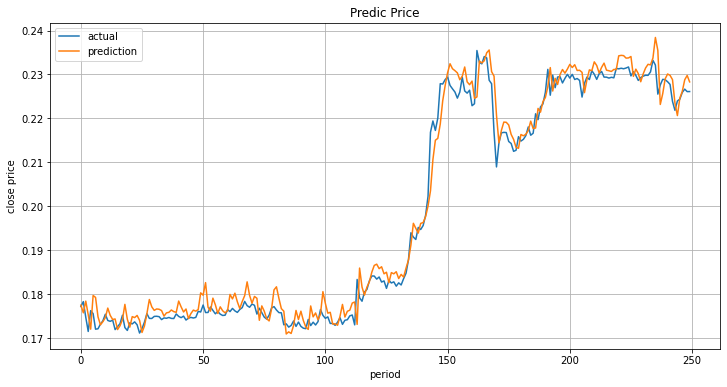

In [34]:
# predic C-Model
c_pred = c_model.predict(cx_test)

plt.figure(figsize=(12, 6))
plt.title('Predic Price')
plt.xlabel('period')
plt.ylabel('close price')
plt.plot(cy_test, label='actual')
plt.plot(c_pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

In [53]:
# Revert normalized predic and actual data
rf_c_pred = pd.DataFrame(c_l_scaler.inverse_transform(c_pred),columns=['pred_close'])
rf_c_test = pd.DataFrame(c_l_scaler.inverse_transform(cy_test),columns=['actual_close'])

plt.figure(figsize=(12, 6))
plt.title('Predic and Actual Price')
plt.xlabel('period')
plt.ylabel('close price')
plt.plot(cy_test, label='actual')
plt.plot(c_pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()